In [ ]:
# ! pip install gymnasium

In [5]:
import gymnasium

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [6]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print(device)

cuda


In [71]:
def plot_scores(scores, env_name, show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(scores, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration' if env_name == 'CartPole-v1' else 'Reward')

    plt.plot(scores_t.numpy())

    # Take 100 episode averages and plot them too
    T = 100
    if len(scores_t) >= T:
        means = scores_t.unfold(0, T, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(T-1), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def plot_scores_compare(scores1, scores2, legend, env_name):
    plt.figure(1)
    scores1_t = torch.tensor(scores1, dtype=torch.float)
    scores2_t = torch.tensor(scores2, dtype=torch.float)

    plt.title(f'Learning Curves ({env_name})')
    plt.xlabel('Episode')
    plt.ylabel('Duration' if env_name == 'CartPole-v1' else 'Reward')

    # plt.plot(scores_t.numpy())

    # Take 100 episode averages and plot them too
    T = 100
    if len(scores1_t) >= T:
        means = scores1_t.unfold(0, T, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(T-1), means))
        plt.plot(means.numpy(), color='red')

    if len(scores2_t) >= T:
        means = scores2_t.unfold(0, T, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(T-1), means))
        plt.plot(means.numpy(), color='orange')

    plt.legend(legend)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.display(plt.gcf())

# DQN Implementation

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQNNet(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQNNet, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


class DQN_Agent():

  def __init__(self, env):
    self.env = env

    self.n_actions = env.action_space.n
    self.state_dim = env.observation_space.shape[0]

    self.policy_net = DQNNet(self.state_dim, self.n_actions).to(device)
    self.target_net = DQNNet(self.state_dim, self.n_actions).to(device)

    self.target_net.load_state_dict(self.policy_net.state_dict())

    self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
    self.memory = ReplayMemory(10000)

    self.steps_done = 0
    self.scores = []

    # Hyperparams
    self.BATCH_SIZE = 128
    self.GAMMA = 0.99
    self.EPS_START = 0.9
    self.EPS_END = 0.05
    self.EPS_DECAY = 1000
    self.TAU = 0.005
    self.LR = 1e-4

  def select_action(self, state):
    sample = random.random()
    eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
        math.exp(-1. * self.steps_done / self.EPS_DECAY)
    self.steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return self.policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

  def optimize_model(self):
    if len(self.memory) < self.BATCH_SIZE:
        return
    transitions = self.memory.sample(self.BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = self.policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()

  def train_main(self):
    
    num_episodes = 50
    if torch.cuda.is_available() or torch.backends.mps.is_available():
      num_episodes = 600

    self.scores.clear()
    self.steps_done = 0

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cum_reward = 0

        for t in count():
            action = self.select_action(state)
            observation, reward, terminated, truncated, _ = self.env.step(action.item())

            cum_reward += reward

            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            self.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            self.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = self.target_net.state_dict()
            policy_net_state_dict = self.policy_net.state_dict()

            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)

            self.target_net.load_state_dict(target_net_state_dict)

            if done:
                break

        self.scores.append(
            (t+1) if self.env.spec.id == 'CartPole-v1' else
            cum_reward
        )

        if i_episode%20==0:
          plot_scores(self.scores, self.env.spec.id)

    plot_scores(self.scores, self.env.spec.id, show_result=True)
    plt.ioff()
    plt.show()



# PPO Implementation

In [ ]:
# PPO Implementation
class PPO_Agent(nn.Module):
    def __init__(self, env):
        super(PPO_Agent, self).__init__()

        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        # Hyperparameters
        self.learning_rate = 0.0005
        self.gamma         = 0.98
        self.lmbda         = 0.95
        self.eps_clip      = 0.1
        self.K_epoch       = 3
        self.T_horizon     = 20

        self.data = []

        self.fc1   = nn.Linear(self.state_dim, 256)
        self.fc_pi = nn.Linear(256, self.action_dim)
        self.fc_v  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.mseLoss = nn.MSELoss()

        self.scores = []

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append(prob_a)
            done_lst.append([int(done)])

        s,a,r,s_prime,done, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done, prob_a

    def optimize_model(self):
        s, a, r, s_prime, done, prob_a = self.make_batch()

        rewards = []
        discounted_r = 0
        for reward, d in zip(reversed(r), reversed(done)):
            if d:
                discounted_r = 0
            discounted_r = reward + self.gamma * discounted_r
            rewards.insert(0, discounted_r)  # insert in front, cannot use append

        rewards = torch.tensor(rewards, dtype=torch.float32)
        if rewards.shape[0]>1:  # a batch with size 1 will cause 0 std
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        rewards = rewards

        for _ in range(self.K_epoch):
            vs = self.v(s)
            advantage = rewards - vs.squeeze(dim=-1).detach()
            vs_target = rewards

            pi = self.pi(s, softmax_dim=-1)
            dist = Categorical(pi)
            dist_entropy = dist.entropy()
            log_p = dist.log_prob(a)
            ratio = torch.exp(log_p - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
            # loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , vs_target.detach()) - 0.01*dist_entropy
            loss = -torch.min(surr1, surr2) + 0.5*self.mseLoss(vs.squeeze(dim=-1) , vs_target.detach()) - 0.01*dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

    def train_main(self):

      score = 0.0
      self.scores.clear()
      print_interval = 20

      num_episodes = 50
      if torch.cuda.is_available() or torch.backends.mps.is_available():
        num_episodes = 600

      for i_episode in range(num_episodes):
          s, _ = self.env.reset()
          cum_reward = 0
          done = False

          for t in count():

              prob = self.pi(torch.from_numpy(s).float())
              m = Categorical(prob)
              a = m.sample().item()
              s_prime, r, term, trunc, info = self.env.step(a)
              # env.render()

              cum_reward += r

              self.put_data((s, a, r/100.0, s_prime, prob[a].item(), term))

              s = s_prime

              score += r
              if term or trunc:
                  break

          self.optimize_model()


          self.scores.append(
              (t+1) if self.env.spec.id == 'CartPole-v1' else
              cum_reward
          )

          if i_episode%20==0:
            plot_scores(self.scores, self.env.spec.id)


      plot_scores(self.scores, self.env.spec.id, show_result=True)
      plt.ioff()
      plt.show()




# Comparision of Algorithms

In [10]:
Cartpole_Env = gymnasium.make("CartPole-v1")

Cartpole_DQN = DQN_Agent(Cartpole_Env)
Cartpole_PPO = PPO_Agent(Cartpole_Env)

#------------------------------------------------

Acrobot_Env = gymnasium.make('Acrobot-v1')

Acrobot_DQN = DQN_Agent(Acrobot_Env)
Acrobot_PPO = PPO_Agent(Acrobot_Env)

### Training DQN in Cartpole Env

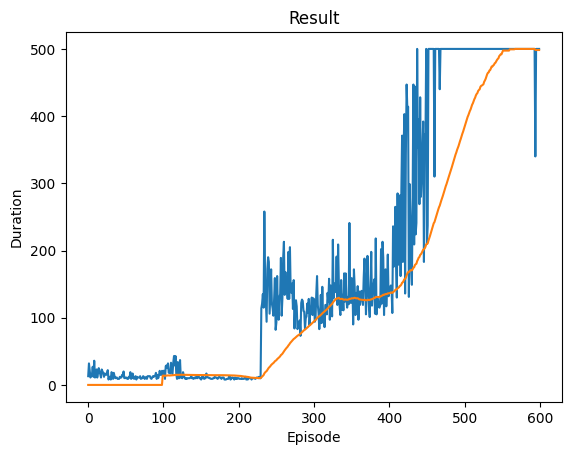

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
Cartpole_DQN.train_main()

### Training PPO in Cartpole Env

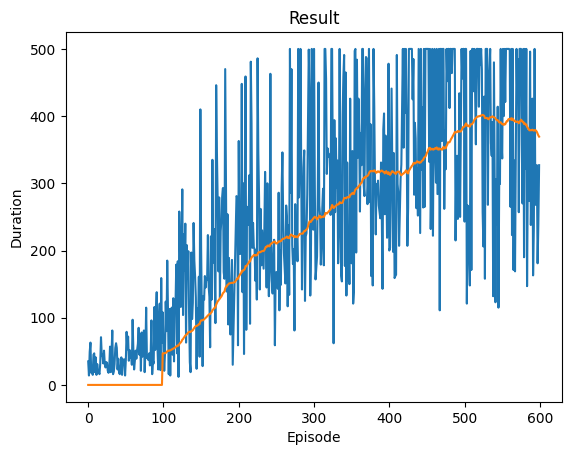

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [52]:
Cartpole_PPO.train_main()

### Training DQN in Acrobot Env

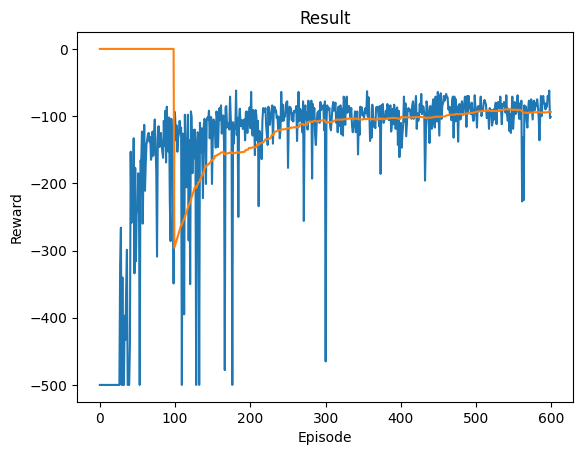

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [53]:
Acrobot_DQN.train_main()

### Training PPO in Acrobot Env

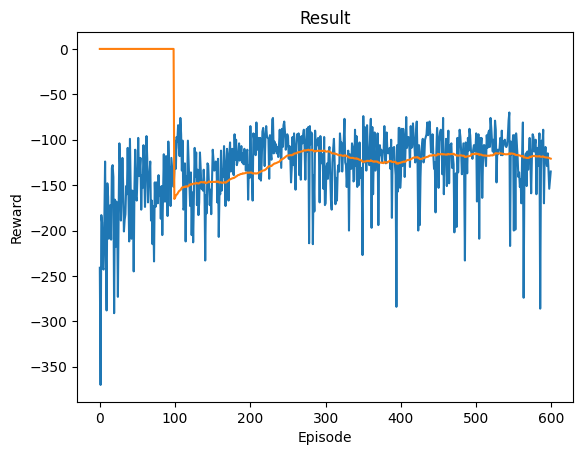

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [54]:
Acrobot_PPO.train_main()

### Comparision of Performance

In [76]:
import pandas as pd


df = pd.DataFrame({
    'DQN': {'Cartpole': max(Cartpole_DQN.scores), 'Acrobot': max(Acrobot_DQN.scores)},
    'PPO': {'Cartpole': max(Cartpole_PPO.scores), 'Acrobot': max(Acrobot_PPO.scores)}
})

df.columns.name = 'Max Reward'

df

Max Reward,DQN,PPO
Cartpole,500.0,500.0
Acrobot,-62.0,-70.0


### Comparision of Learning Curves

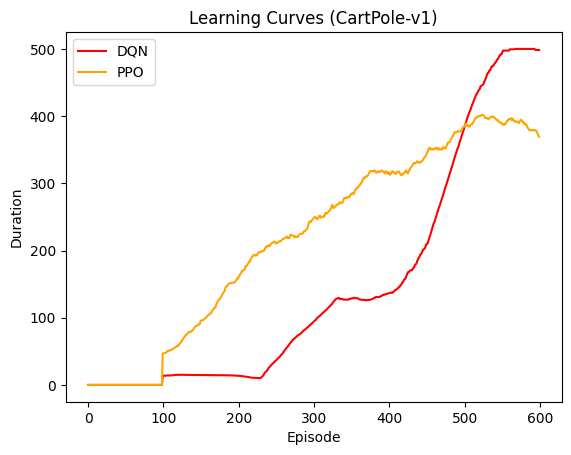

<Figure size 640x480 with 0 Axes>

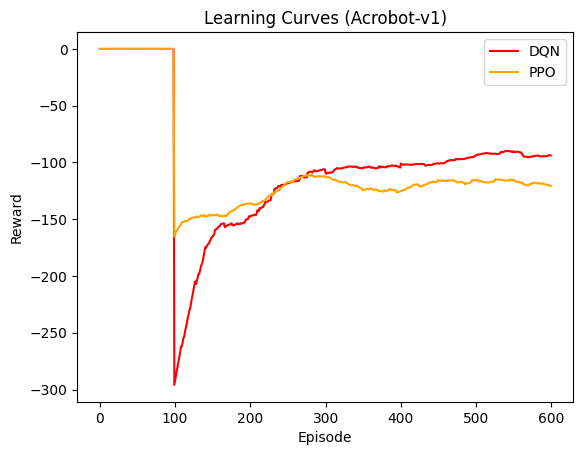

<Figure size 640x480 with 0 Axes>

In [72]:
plot_scores_compare(
    Cartpole_DQN.scores,
    Cartpole_PPO.scores,
    ['DQN', 'PPO'],
    'CartPole-v1'
)

plot_scores_compare(
    Acrobot_DQN.scores,
    Acrobot_PPO.scores,
    ['DQN', 'PPO'],
    'Acrobot-v1'
)

# Conclusion


* **Performance**: From the performance comparision table above, it is clear that the best performance of both the algorithms are almost the same. But, considering the mean performance (from learning curves), DQN shows better mean performance than PPO consistently.

* **Data Efficiency**: Clearly, DQN is more data efficient compared to PPO. This is seen from the steep learning curves of DQN. In both the environments, DQN surpasses the performance of PPO after a point. This indicates that DQN is able to learn better from fewer experiences/interaction with the environment.

* **Advantages and Disadvantages**:
  - DQN is more sample-efficient because it can reuse past experiences stored in a replay buffer, learning from them multiple times. Whereas, PPO is less-sample efficient because of its on-policy nature.
  - DQN is not suitable for continuous action spaces, but PPO can be used for environments with continuous action spaces.
  - Training time for DQN is much higher than that of PPO. PPO converges faster.



